# SubReddit Classifier

## Executive Summary

Reddit has identified that they have lost the tags for 2 of their subreddits for a few days and they are **r/buildapc** and **r/Cooking**.  
Fortunately, there's a backup for the 2 subreddits. However, posts relating to the 2 subreddits during this period have had no classification. You have been tasked to classify the tagless posts into their correct subreddits with an appropriate model.  

This project aims to correctly classify the subreddits, and select a model after comparing the efficacy and limitations of two classification models.


### Contents:
- [Data Import and Cleaning](#Data-Import-and-Cleaning)
- [Natural Language Processing](#Natural-Language-Processing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Logistic Regression](#Logistic-Regression)
- [Naive Bayes](#Naive-Bayes)
- [Conclusion](#Conclusion)

In [1]:
import requests
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import string
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

# Data Import and Cleaning

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
cooking= pd.read_csv('./datasets/cooking_posts.csv')
bapc= pd.read_csv('./datasets/bapc_posts.csv')

In [3]:
print(cooking.shape)
print(bapc.shape)

(987, 104)
(998, 103)


Our dataset seems to have around 100+ columns of information. However, we are only interested in the text that which each post contains as it is the primary information that will aid us in our modelling and classifying later on.  
The columns that hold the test we deem important would be the ***title***, and ***selftext***.  
We would also need our classification, which would be ***subreddit*** in this context.

In [4]:
#we only want the title, selftext and our classfier is subreddit
cooking = cooking[['title', 'subreddit', 'selftext']]
bapc = bapc[['title', 'subreddit', 'selftext']]

In [5]:
#making sure we dont have duplicate posts
cooking.drop_duplicates(subset=['title','selftext'],keep=False)
bapc.drop_duplicates(subset=['title','selftext'],keep=False)

,title,subreddit,selftext
0,"Simple Questions - May 08, 2020",buildapc,This thread is for simple questions that don't...
1,Ryzen 3 3100 and 3300X Review Megathread,buildapc,# SPECIFICATIONS\n\n|Specs|3100|3300X|3200G|Ry...
2,Make sure you heat up your thermal paste befor...,buildapc,Ryzen processors have a thing with being pulle...
3,The R3 3300X release has really opened my eyes...,buildapc,I really doubt they'll hold up well in the fut...
4,Thanks Zotac and BAPC mods -- my 2M prize has ...,buildapc,Hello r/buildapc! In the [2 million subscribe...
5,Is now a good time to build a pc?,buildapc,So I decided that I was gonna put 250$ into a ...
6,Yaaaay. I did it. Build complete.,buildapc,My first build: \nhttps://pcpartpicker.com/lis...
7,"22 Years Since First Build, 7 Years Since Last...",buildapc,Wow... I love stepping away (I swore I'd never...
8,Don’t be like me - check your clock speeds for...,buildapc,I feel like this could benefit someone out the...
9,Best 144hz monitor under 200?,buildapc,"Right now I’m using a 60hz monitor, but I woul..."


In [6]:
print(cooking.shape)
print(bapc.shape)

(987, 3)
(998, 3)


In [7]:
#now we combine our two data sets
data = pd.concat([bapc,cooking], axis=0)
data.reset_index(inplace=True, drop=True)
data.head(20)

,title,subreddit,selftext
0,"Simple Questions - May 08, 2020",buildapc,This thread is for simple questions that don't...
1,Ryzen 3 3100 and 3300X Review Megathread,buildapc,# SPECIFICATIONS\n\n|Specs|3100|3300X|3200G|Ry...
2,Make sure you heat up your thermal paste befor...,buildapc,Ryzen processors have a thing with being pulle...
3,The R3 3300X release has really opened my eyes...,buildapc,I really doubt they'll hold up well in the fut...
4,Thanks Zotac and BAPC mods -- my 2M prize has ...,buildapc,Hello r/buildapc! In the [2 million subscribe...
5,Is now a good time to build a pc?,buildapc,So I decided that I was gonna put 250$ into a ...
6,Yaaaay. I did it. Build complete.,buildapc,My first build: \nhttps://pcpartpicker.com/lis...
7,"22 Years Since First Build, 7 Years Since Last...",buildapc,Wow... I love stepping away (I swore I'd never...
8,Don’t be like me - check your clock speeds for...,buildapc,I feel like this could benefit someone out the...
9,Best 144hz monitor under 200?,buildapc,"Right now I’m using a 60hz monitor, but I woul..."


In a classifier such as this, there only outcomes are, buildapc or cooking. We can classify that in this context that if a post is not buildapc, it is cooking. This is a bernoulli classification and therefore our outcomes can be binary, with buildapc as 1 and cooking as 0.  

Also since both our ***title*** and ***selftext*** are texts that we will eventually be tokenized, it is better for us to combine the 2 columns as it would be easier to handle.

In [8]:
#making subreddit as binary classification with buildapc as 1 and cooking as 0.
data['bapc'] = (data['subreddit']=='buildapc')*1
data['bapc'].value_counts()

1    998
0    987
Name: bapc, dtype: int64

In [9]:
data['title'] = data['title'].astype(str)
data['selftext']=data['selftext'].astype(str)
data['text'] = data['title']+data['selftext']

# Natural Language Processing

In the case of our modelling, we are only interested in the actual words within the post itself. Non textual data does not hold much value in assisting with our modelling and therefore should be dropped. Non-textual data includes punctuation, digits and urls.

In [10]:
#we use regex to get rid of out non-textual data
def clean_text(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)#removing links
    text = text.lower()  #making eveything lower case
    text = re.sub('\[.*?()\]','',text) #removing some punctuation
    text = re.sub('[%s]'%re.escape(string.punctuation),'',text)  #removing more punctuation
    text = re.sub('\w*d\w*','',text) #removing words with numbers in them
    text = re.sub('\d','',text) #removing numbers
    text = re.sub('\n','',text) #removing newlines
    return text

cleaner= lambda x: clean_text(x)

In [11]:
data['text'] = data['text'].apply(cleaner)

In [12]:
data['text'].head()

0    simple questions  may  this  is for simple que...
1    ryzen    x review  specificationsspecsxgryzen ...
2    make sure you heat up your thermal paste befor...
3    the r x release has really  my eyes to the fac...
4    thanks zotac  bapc   my m prize has    in the ...
Name: text, dtype: object

In [13]:
#some of them still have links in text form, lets remove those as well
data['text'] = data['text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

Now that all the text has been cleaned to just words alone, we can see that there are some words that are essentially variations of a single root word. For example the words check, checks and checking are all simply variations of the word come. Counting them as separate words would just unnecessarily lengthen the different types of words we consider in our model.  

A process called lemmatizing would be used in this case. Lemmatizing reduces such words to their root words. The process of lemmatizing would require tokenizing of each individual word and a lemmatizer applied to each word.

Below, is our lemmatizing workflow. The words in each post is tokenized into a list and then lemmatized. However, this list is not a desirable format and as such, we convert it back into a string to be processed later on.

In [14]:
w_tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

#creating a function to lemmatize each word in the tokenized text
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

data['text']= data['text'].apply(lemmatize_text)

#Since our posts are in list format, we change them back into string format without the commas
data['text'] = data['text'].apply(', '.join).str.replace(',','')

In [15]:
#assign our Xs and Ys
X = data['text']
y = data['bapc']

In [16]:
#splitting to create model from our train data and subsequently evaluate the model performance on our test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

In [17]:
#checking if our data is correctly split
X_train.shape

(1488,)

In [18]:
y_train.shape

(1488,)

In [19]:
X_test.shape

(497,)

In [20]:
y_test.shape

(497,)

## Creating our word matrix

We have all our text in their stemmed versions, it is time to create our Word Matrix.  
Here we would use a CountVectorizer. The CountVectorizer splits the posts into possible words that could occur in all posts and counts their occurences in each post.  
Despite reducing our words to their stem words, there are words that hold no real value, such as filler words. These words are called Stop Words and we want to exclude them from our model.

In [21]:
# Instantiate our CountVectorizer.
cvec = CountVectorizer(max_features=500, stop_words='english')

In [22]:
#We only fit to our training data
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).todense(), columns= cvec.get_feature_names())

In [23]:
X_train_cvec.head()

,able,actually,af,ago,air,amazing,amazon,amp,appreciate,ask,asrock,asus,atx,available,away,bacon,bag,bake,baking,bamph,banana,base,basic,basically,batch,bean,beef,best,better,big,bios,bit,black,bm,boot,bought,bowl,box,breast,bronze,brown,built,butter,buy,buying,cable,cake,came,care,case,cast,change,cheap,cheaper,check,cheese,chef,chicken,chili,chilli,chip,chocolate,choice,clean,clock,clove,come,coming,compatibility,compatible,completely,component,computer,connector,cook,cookbook,cooking,cool,cooler,cooling,core,corn,corsair,cost,country,couple,course,cover,cpu,crash,crazy,cream,cup,curious,current,currently,curry,cut,cutting,easy,eat,egg,enjoy,error,especially,evga,evo,expensive,experience,extra,extremely,family,fan,far,fat,favorite,feel,ff,figure,file,finally,fine,fish,fit,fix,flavor,flour,fps,framerate,free,freezer,fresh,frozen,fry,frying,future,game,gaming,garlic,gb,geforce,gen,getting,ghz,gigabyte,given,glass,gm,going,got,gpu,graphic,gravy,great,greatly,green,grill,grocery,gskill,gtx,guess,guy,ha,half,hate,havent,having,hear,heat,heavy,help,hi,high,higher,hit,home,hope,hoping,hot,hour,huge,hz,ice,ill,im,inch,information,input,install,instruction,intel,internet,iron,isnt,issue,ive,juice,just,kitchen,knife,know,laptop,large,later,le,learn,left,leftover,lemon,let,level,light,like,lime,link,list,little,live,ll,local,lol,long,longer,look,looking,lot,love,low,lower,mailin,main,mainly,make,making,market,matter,max,maybe,mb,meal,mean,meat,memory,mhz,milk,min,minute,mix,mixture,ml,mm,mobo,moment,money,monitor,month,morning,mother,mouse,msi,new,newegg,nice,night,normal,number,nvme,nzxt,obviously,oc,oil,ok,okay,olive,onion,online,open,operating,opinion,option,oven,pan,past,pasta,paste,pc,pci,pcie,people,pepper,performance,picture,pie,piece,pin,pizza,place,plan,planning,plastic,play,playing,plug,plus,point,pork,port,possible,post,pot,potato,potential,power,prebuilt,pretty,price,pro,probably,problem,process,processor,properly,psu,purchase,purchasing,putting,quality,quarantine,question,quite,ram,range,ratio,real,really,reason,rebate,recently,recipe,remove,replace,research,resolution,rest,restaurant,result,rgb,rice,rig,right,roast,rog,room,rtx,run,running,rx,ryzen,safe,salt,samsung,sata,sauce,save,saw,say,screen,screw,seagate,seasoning,seeing,seen,series,set,setting,setup,share,shipping,short,signal,similar,simple,simply,single,size,skillet,slice,slot,slow,small,smell,smooth,software,soon,sorry,soup,space,spec,specific,spice,stainless,start,starting,state,stay,steak,steel,step,stick,stir,stock,storage,store,stove,streaming,strix,stuff,style,sugar,suggestion,super,supply,support,sure,sweet,switch,taking,taste,tasty,tax,tb,tbsp,tell,temp,temperature,test,texture,thank,thanks,thats,thermal,thing,think,thinking,thought,ti,time,tip,title,tomahawk,tomato,tonight,took,total,tower,trouble,try,trying,tsp,turn,type,uk,ultra,usb,use,using,usually,ve,vegetable,veggie,vengeance,version,vr,wa,wait,wanna,want,wasnt,waste,water,watt,way,week,went,whats,white,wifi,wine,wish,won,wont,work,working,worth,wrong,xgb,xt,year,yeast,youtube
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

# Exploratory Data Analysis

In [24]:
pd.DataFrame(X_train_cvec.sum().sort_values(ascending=False)[:20]).transpose()

,im,just,pc,wa,like,make,want,recipe,know,cpu,use,new,help,gb,case,looking,time,gaming,ive,best
0,655,650,622,589,524,448,382,368,362,348,344,343,330,328,325,311,307,298,295,259


### Note:  
Here is a list of top 20 words used in the posts. It can be clearly seen that there are words that really dont hold any value in our model. Words like 'im', 'just', 'like', 'new', 'want', 'use', 'ive', 'really' are examples of words that do not add any significance in assisting in our classification model. Therefore these words should be considered as stop words, and added to our stop words list during the CountVectorising process.

In [25]:
#we do not fit to our test data, just transform
X_test_cvec = pd.DataFrame(cvec.transform(X_test).todense(), columns= cvec.get_feature_names())

In [26]:
pd.DataFrame(X_test_cvec.sum().sort_values(ascending=False)[:20]).transpose()

,pc,im,just,wa,like,make,know,help,want,new,cpu,time,use,gaming,case,looking,recipe,cooking,ive,power
0,229,222,207,205,172,149,134,132,118,117,113,110,103,103,101,99,95,94,93,92


### More stop words
The same applies for our X_test as well.  
Here we can eyeball which words we want to add onto our stop words. 
We also want to remove the giveaway words like build, pc and cooking.  
##### Additional stop words:
 - im
 - just
 - like
 - new
 - want
 - use
 - ive
 - really

In [27]:
add_stop_words = ['im','just','like','new','want','use','ive','really','build','computer','pc','cook','come','coming']

In [28]:
from sklearn.feature_extraction import text 
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

#### Now we redo our CountVectorizer with these additional stop words

In [29]:
cvec = CountVectorizer(max_features=500, stop_words=stop_words)
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).todense(), columns= cvec.get_feature_names())
X_test_cvec = pd.DataFrame(cvec.transform(X_test).todense(), columns= cvec.get_feature_names())
# we have refit our CountVectorizer and the top 20 words should be more significant to our modelling now

In [30]:
pd.DataFrame(X_train_cvec.sum().sort_values(ascending=False)[:20]).transpose()

,wa,make,recipe,know,cpu,help,gb,case,looking,time,gaming,best,fan,ha,amazon,cooking,power,gpu,chicken,game
0,589,448,368,362,348,330,328,325,311,307,298,259,251,250,242,241,233,229,224,222


In [31]:
pd.DataFrame(X_test_cvec.sum().sort_values(ascending=False)[:20]).transpose()

,wa,make,know,help,cpu,time,gaming,case,looking,recipe,cooking,power,fan,gb,monitor,game,ha,amazon,gpu,ram
0,205,149,134,132,113,110,103,101,99,95,94,92,91,86,83,82,80,79,78,78


## Subreddit Word Clouds

Seeing the frequency of these words in tabloid form may get quite dull. Word Clouds are a great visual representation to see the most frequently used words in each subreddit.  
Below is the code to generate this Word Cloud

In [32]:
def word_cloud(word_matrix):
    text = ' '
    stopwords = set(stop_words)
    # iterate through the wordmatrix
    for x in word_matrix :
        x = str(x)
        # split the values
        values = x.split()
        # Converts each token into lowercase
        for i in range(len(values)):
            values[i] = values[i].lower()
        for words in values:
            text = text + words + ' '
    wc = WordCloud(max_words= 100,
                          width = 744,
                          height = 544,
                          background_color ='white',
                          stopwords=stopwords,
                          contour_width=3,
                          contour_color='steelblue',
                          min_font_size = 10).generate(text)
    # plot the WordCloud image
    plt.figure(figsize = (14, 14))
    plt.imshow(wc)
    plt.axis("off");
    #plt.savefig('../images/reddit_wordcloud.png')

In [33]:
bapc.head()

,title,subreddit,selftext
0,"Simple Questions - May 08, 2020",buildapc,This thread is for simple questions that don't...
1,Ryzen 3 3100 and 3300X Review Megathread,buildapc,# SPECIFICATIONS\n\n|Specs|3100|3300X|3200G|Ry...
2,Make sure you heat up your thermal paste befor...,buildapc,Ryzen processors have a thing with being pulle...
3,The R3 3300X release has really opened my eyes...,buildapc,I really doubt they'll hold up well in the fut...
4,Thanks Zotac and BAPC mods -- my 2M prize has ...,buildapc,Hello r/buildapc! In the [2 million subscribe...


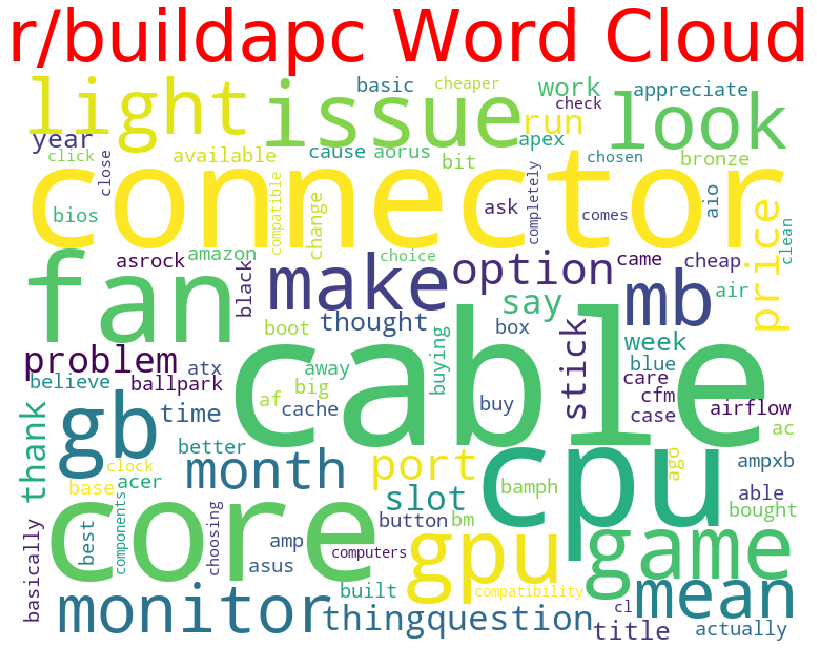

In [34]:
bapc['text'] = bapc['title']+bapc['selftext']
bapc['text'] = bapc['text'].astype(str)
bapc['text'] = bapc['text'].apply(cleaner)
bapc_cvec = pd.DataFrame(cvec.fit_transform(bapc['text']).todense(), columns= cvec.get_feature_names())
word_cloud(bapc_cvec)
plt.title('r/buildapc Word Cloud', fontsize=72, color='r');

In [35]:
cooking.head()

,title,subreddit,selftext
0,My go to for angel hair dressing is tomatoes t...,Cooking,The pasta itself isn't the star of the dish. ...
1,Does anyone else not really enjoy the food aft...,Cooking,"Sometimes when I cook a meal, I can’t even rea..."
2,I have been making avocado oil mayo at home fo...,Cooking,I never bothered making it completely from scr...
3,What’s something you started making from scrat...,Cooking,"Mine is whipped topping (Sorry Cool Whip, byeee)"
4,An oven roasted Onion is one of the most simpl...,Cooking,I had some leftover onion which I didn't know ...


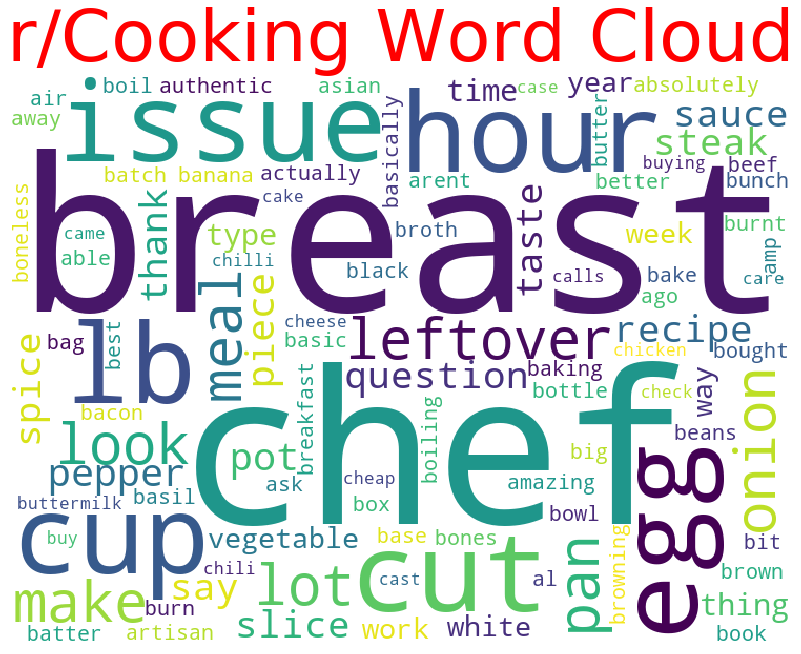

In [36]:
cooking['text'] = cooking['title']+cooking['selftext']
cooking['text'] = cooking['text'].astype(str)
cooking['text'] = cooking['text'].apply(cleaner)
cooking_cvec = pd.DataFrame(cvec.fit_transform(cooking['text']).todense(), columns= cvec.get_feature_names())
word_cloud(cooking_cvec)
plt.title('r/Cooking Word Cloud', fontsize=72, color='r');

### Observations:  
The differences between the most frequent words in both subreddits are quite stark. Its clear that they are very very different. We can expect our model to do fairly well in its ability classify the subreddits.  

We can now start our modelling!

# Logistic Regression

In [37]:
#creating a pipe of CountVectorizer and Logistic Regression
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stop_words)),
    ('lr', LogisticRegression(solver = 'lbfgs'))
])

In [38]:
#giving our selection of parameters to choose from
pipe_params = {
    'cvec__max_features': [200,300,400,500],
    'cvec__min_df': [1,2],
    'cvec__max_df': [.9, .95],
}

In [39]:
#hyperparameter tuning
gs = GridSearchCV(pipe, 
                  param_grid=pipe_params,
                  cv=5)

In [40]:
gs.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [41]:
print(gs.best_score_)

0.9637064153842678


In [42]:
#best parameters
gs.best_params_

{'cvec__max_df': 0.9, 'cvec__max_features': 500, 'cvec__min_df': 1}

First we created a pipeline of our transformer and estimator, in this case being CountVectorizer and Logistic Regression. We then list parameters to choose from because at this point, we don't know what're the best parameters to utilise. GridSearch is then used as an iterative method to select the best combination of parameters which produce the highest accuracy. Afterwhich we can see the parameters selected and choose this for our model.

Logistic Regression was the model selected here. It uses a logistic function to model a binary dependant variable and in this case, used as a classifier.

In [43]:
#This is the model with the best estimators generated from the GridSearch
gs_model = gs.best_estimator_

In [44]:
#how well our model fares in our train data
gs_model.score(X_train, y_train)

0.991263440860215

In [45]:
#how well our modeal fares with our test data
gs_model.score(X_test, y_test)

0.9557344064386318

In [46]:
#generating predictions from our test
predictions = gs_model.predict(X_test)

A ***confusion matrix*** is a good representation of how well our model fares. It reveals the correct predictions and the wrong predictions under which class, such as **False Positives** and **False Negatives**. Depending on context, we may favour one over the other. 

In [47]:
#creating a confusion matrix
confusion_matrix(y_test,predictions)

array([[235,  12],
       [ 10, 240]], dtype=int64)

In [48]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [49]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 235
False Positives: 12
False Negatives: 10
True Positives: 240


In [50]:
#we generate specificity and sensitivity of our model performance
spec = tn/(tn+fp)
print(f'Specificity: {round(spec,4)}')

sens = tp/(tp+fn)
print(f'Sensitivity: {round(sens,4)}')

Specificity: 0.9514
Sensitivity: 0.96


*Specificity* is a measure of true negative rate in comparison to the total negative predictions.  
*Sensitivity* is a measure of true positive rate in comparison to the total negative predicitons. 


The higher the value, the more accurate the predictions are. As it is a measure of level of truth in its classification there are scenarios where we would prefer sensitivity over specificity (prefer less false negatives over less false positives), usually in the medical industry where false negatives are interpreted to be worse than false positives.

## ROC AUC

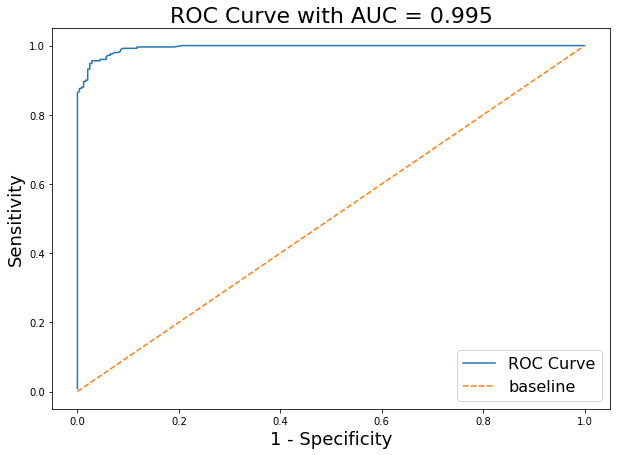

In [51]:
pred_proba = [i[1] for i in gs_model.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

roc_auc_score(pred_df['true_values'],pred_df['pred_probs'])

# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

The ROC-AUC curve is a representation of True Positive Rate against False Positive Rate.   
The dotted line represents an AUC value of 0.5 which means there is no discernable seperation between our positive and negative class.  
The higher the AUC value, the higher the measure of seperability, in other words, the better the ability to classify between our binary classification.  


Therefore with our model having a AUC value of 0.995 which is extremely close to 1, it has a very good degree of seperability.

# Naive Bayes

#### The same work flow applies for our Naive Bayes as well.

In [52]:
pipe2 = Pipeline([
    ('cvec', CountVectorizer(stop_words=stop_words)),
    ('nb', MultinomialNB())
])

In [53]:
#giving our selection of parameters to choose from
pipe2_params = {
    'cvec__max_features': [200,300,400,500],
    'cvec__min_df': [1,2],
    'cvec__max_df': [.9, .95],
}

In [54]:
#hyperparameter tuning
gs_nb = GridSearchCV(pipe2, 
                  param_grid=pipe2_params,
                  cv=5)

In [55]:
gs_nb.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [56]:
#the best score we get from our cross validation
print(gs_nb.best_score_)

0.9751384086954558


In [57]:
#best paramters selected by our GridSearch
gs_nb.best_params_

{'cvec__max_df': 0.9, 'cvec__max_features': 500, 'cvec__min_df': 2}

In [58]:
gs_nb_model = gs_nb.best_estimator_

In [59]:
#how well our model fares in our train data
gs_nb_model.score(X_train, y_train)

0.9811827956989247

In [60]:
#how well our model fares in our test data
gs_nb_model.score(X_test, y_test)

0.9758551307847082

In [61]:
predictions = gs_nb_model.predict(X_test)

In [62]:
#creating our confusion matrix
confusion_matrix(y_test,predictions)

array([[238,   9],
       [  3, 247]], dtype=int64)

In [63]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [64]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 238
False Positives: 9
False Negatives: 3
True Positives: 247


In [65]:
#we generate specificity and sensitivity of our model performance
spec = tn/(tn+fp)
print(f'Specificity: {round(spec,4)}')

sens = tp/(tp+fn)
print(f'Sensitivity: {round(sens,4)}')

Specificity: 0.9636
Sensitivity: 0.988


We have more false positives than we do false negatives

#### Note:  
With pipeline, we cannot treat the pipe as a model in of itself. As such the attributes of these are unable to be accessed in pipe. However, we an assign a name t0 the fitted model and then access our atrributes through the assigned name.

## Important Features in our Classifier

In [66]:
#assigning name to our model
Transformer = gs_nb.best_estimator_.named_steps['cvec']
Classifier = gs_nb.best_estimator_.named_steps['nb']

In [67]:
Classifier.coef_[0,:10]

array([-5.66988092, -6.60988818, -6.69326979, -6.19117785, -6.65071018,
       -8.44246965, -4.36917849, -6.27341594, -7.12071381, -6.42756662])

In [68]:
neg_class = Classifier.feature_log_prob_[0,:].argsort()
pos_class = Classifier.feature_log_prob_[1,:].argsort()

print('Top 10 features for Cooking:',np.take(Transformer.get_feature_names(), neg_class[::-1][:10]))
print('Top 10 features for Buildapc:',np.take(Transformer.get_feature_names(), pos_class[::-1][:10]))

Top 10 features for Cooking: ['recipe' 'make' 'wa' 'cooking' 'chicken' 'pan' 'time' 'sauce' 'making'
 'know']
Top 10 features for Buildapc: ['cpu' 'gb' 'case' 'wa' 'gaming' 'fan' 'amazon' 'power' 'know' 'gpu']


Above are the coefficients of the words and the lists of most important features for our positive and negative classes. The features are dstinctly different except for the words 'know' and 'wa'. We could add these words into our list of stop words, as they hold high weightage in both classes, they dont contribute to the class seperability.

## ROC AUC

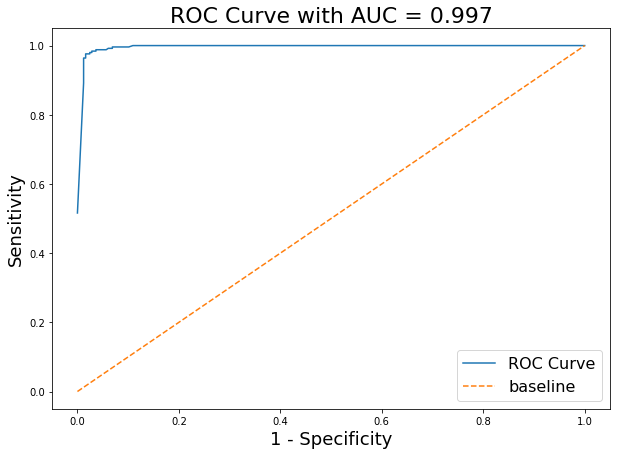

In [69]:
pred_proba = [i[1] for i in gs_nb_model.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

roc_auc_score(pred_df['true_values'],pred_df['pred_probs'])

# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);
#plt.savefig("figure.png")

Our ROC AUC Curve with AUC value of 0.997 for our Naive Byes is in fact better than our Logistic Regression with value 0.995. This means that it has better seperability, between the two classes. In other words, there is less of an overlap between the two classes in Naive Bayes as compared to Logistic Regression. The AUC value alone does not represent which model is better as it does not take into account the weights of the features involved in predicting the classifications.

## Misclassified Posts

In [70]:
#creating Dataframe of results
results = pd.DataFrame(y_test)
results['predicted'] = predictions
results.sort_index()
#acquiring those that do not match, basically the misclassified posts
row_index = results[results['bapc']!= results['predicted']].index

In [71]:
print('There are',len(row_index),'misclassified posts')
row_index

There are 12 misclassified posts


Int64Index([1267, 1833, 1882, 1869, 1250, 1228, 1249, 940, 1559, 390, 378,
            1643],
           dtype='int64')

In [72]:
results.loc[1267]

bapc         0
predicted    1
Name: 1267, dtype: int32

In [73]:
data.loc[1267,'text']

'cookware chain sur la table inc is preparing for a potential bankruptcy im going to keep an eye on their website for clearance sale'

From the above, we can see that the text does not really use any specific words related to cooking other than the word cookware, for example. The weight of the words in this text in our model pushed it towards classifying it under buildapc instead of cooking.  

In this case, it is apparent that there are more stop words required to be filtered out. As frequently used as they are, they hold no meaning to our classifier.  

This brings us to see the limitations of our model and the nature of the classifier having brought too much weight on words that do not necessarily contribute to the classification. This means that there is always more work to be done during the preprocessing section and that should bump our classification accuracy even more.

# Conclusion

In [74]:
gs_model.score(X_test, y_test)

0.9557344064386318

In [75]:
gs_nb_model.score(X_test, y_test)

0.9758551307847082

Model scores:
- Logistic Regression = 0.9557
- Naive Bayes = 0.9758

Our Naive Bayes model performed better than our Logistic Regression and it can successfully predict our classification of posts correctly at a 97.5% accuracy.

Logistic Regression makes a prediction for the probability using a direct functional form where as Naive Bayes figures out how the data was generated given the results. Therefore with a larger dataset Logistic Regression would perform better as it would have better probability tuned to the model vs Naive Bayes that is a generative model[1].

<ins>Citations<ins>    
[1] Deb, S. (2016, March 21). Naive Bayes vs Logistic Regression. Retrieved from https://medium.com/@sangha_deb/naive-bayes-vs-logistic-regression-a319b07a5d4c